# Pytorch Workflow

In [1]:
import torch
from torch import nn # nn contains all off Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check Pytorch version
torch.__version__

'2.8.0+cu128'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *know* data using linear regression formula.

We'll use a linear regression formula to make a straight line with know **parameters**

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1) # adds extra dimension
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splititting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data

In [3]:
# Create a train/test split
train_split = int (0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

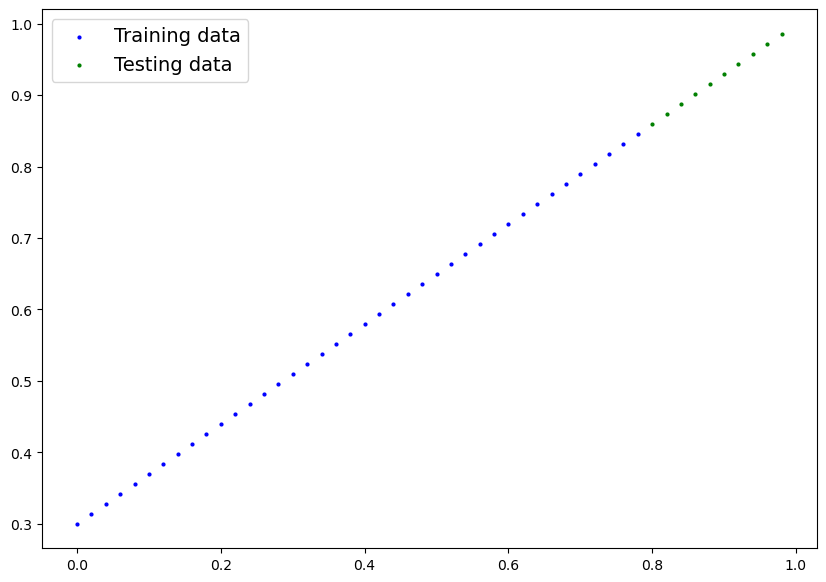

In [5]:
plot_predictions()

## 2. Build Model

What our model does:

* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get colser to)
the ideal values (the weight and bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [6]:
# Create Linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherhits from nn.Module
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(
            1, # <- start with a random weight and try to adjust it to the ideal weight
            requires_grad=True, # requires gradient, it's default=True
            dtype=torch.float
        ))
        
        self.bias = nn.Parameter(torch.randn(
            1,
            requires_grad=True,
            dtype=torch.float
        ))

        # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- 'x' is the input data
        return self.weight * x + self.bias


### Pytorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.Parameter - what parameters should your model try to learn, often a Pytorch layer from torch.nn wil set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite the foward()
* torch.optim - This where the optimizers in Pytorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the foward computation

### Checking the contents of our Pytorch model

Now we've created a model, let's see what's inside..

So we can check our model parameters or what's inside our model using *.parameters()*

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inferance_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the forward() method.

In [9]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

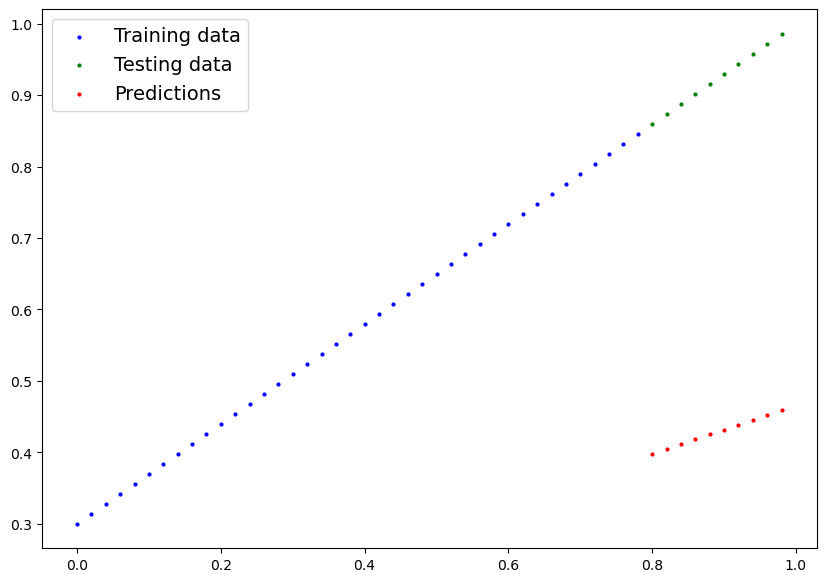

In [11]:
plot_predictions(predictions=y_pred)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss funciont**: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (weight and bias, in our case) to improve the loss function.
    * Inside the optimizer you'll often have to set two parameters:
        - params: The model parameters you'd like to optimize, for example ```params=model_0.parameters()```
        - lr (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step (a small lr results in small changes, a large lr results in large changes)

And specifically for Pytorch, we need:
* A training lopp
* A testing loop

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# Check out our model's parameters

model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()
# MAE_loss = torch.mean(torch.abs(y_pred - y_test))

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.01) # lr lerarning rate 

## Building a training loop (and a testing loop) in Pytorch

A couple of things we need in a training loop:

0. Loop Through the data
1. Forward pass to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
torch.manual_seed(42)

# An epoch is one loop through the data...
epochs = 200

# Track different values
epoch_count = []
loss_values =[]
test_loss_values =[]

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode 
    model_0.train() # Train mode in pytorch sets all parameters that require gradients to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(f'Loss {loss}')

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default the optimizer changes will accumulate through the loop so... we have to zero them

    # Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/ batch norm layers)
    with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes
    # with torch.no_grad(): # You may also see torch.no_grad() in older pytorch code
        # 1. Do the foward pass
        test_pred = model_0(X_test)

        # 2 . Calculare the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        print(f'Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}')

    # Print out model state_dict()


Loss 0.31288138031959534
Epoch: 0 | Test: 0.31288138031959534 | Test loss: 0.48106518387794495
Loss 0.3013603389263153
Loss 0.28983935713768005
Loss 0.2783183455467224
Loss 0.26679736375808716
Loss 0.2552763521671295
Loss 0.24375534057617188
Loss 0.23223432898521423
Loss 0.22071333229541779
Loss 0.20919232070446014
Loss 0.1976713240146637
Epoch: 10 | Test: 0.1976713240146637 | Test loss: 0.3463551998138428
Loss 0.18615034222602844
Loss 0.1746293306350708
Loss 0.16310831904411316
Loss 0.1515873372554779
Loss 0.14006635546684265
Loss 0.1285453587770462
Loss 0.11702437698841095
Loss 0.1060912236571312
Loss 0.09681284427642822
Loss 0.08908725529909134
Epoch: 20 | Test: 0.08908725529909134 | Test loss: 0.21729660034179688
Loss 0.08227583020925522
Loss 0.07638873159885406
Loss 0.07160007208585739
Loss 0.06747635453939438
Loss 0.06395438313484192
Loss 0.06097004935145378
Loss 0.05845819041132927
Loss 0.05635259300470352
Loss 0.0545857772231102
Loss 0.053148526698350906
Epoch: 30 | Test: 0.053

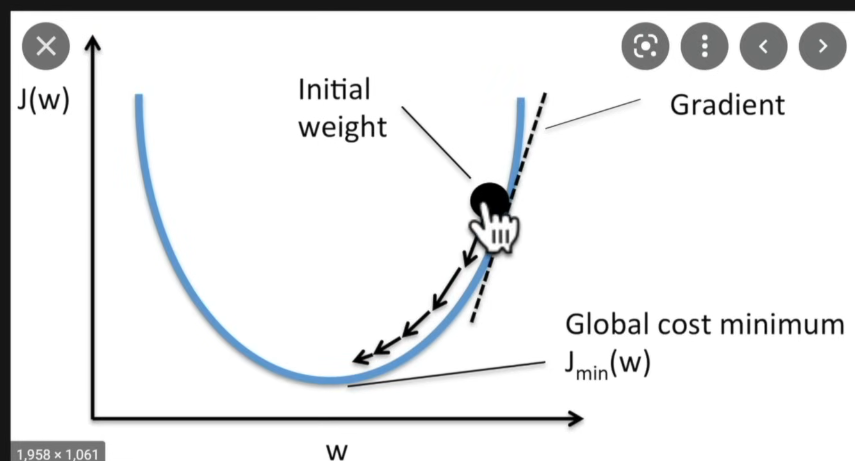

In [17]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [18]:
with torch.inference_mode():
    y_pred_new = model_0(X_test)

In [19]:
weight, bias

(0.7, 0.3)

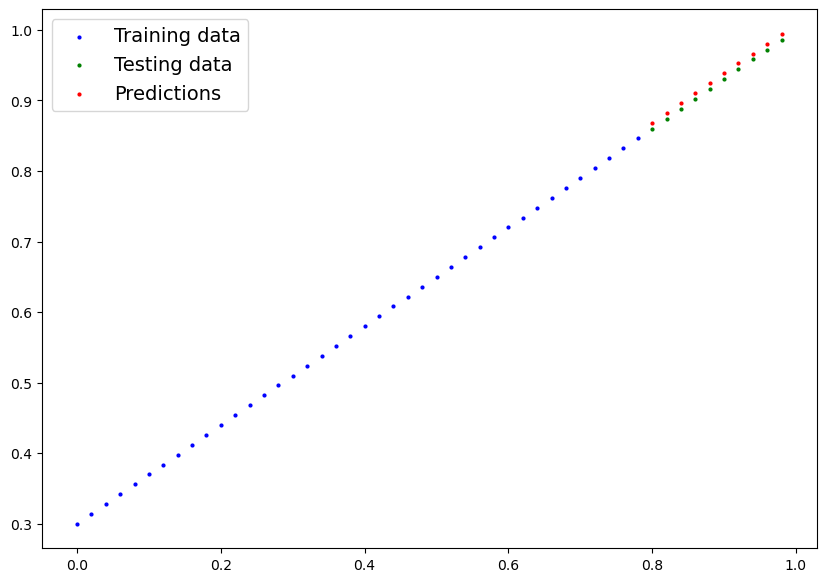

In [20]:
plot_predictions(predictions=y_pred_new)

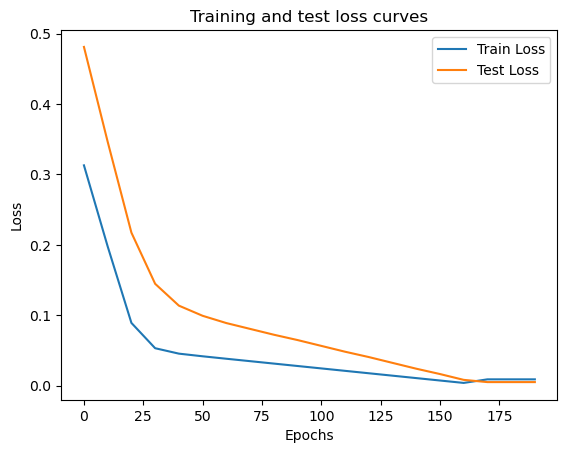

In [24]:

plt.plot(epoch_count, loss_values, label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')

plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Saving a model in Pytorch

There are three main methods you should about for saving and loading models in Pytorch

1. `torch.save()` - allows you save a Pytorch object in Python's pickle format
2. `torch.load()` - allow you load a saveed Pytorch object
3. `torch.nn.Module.load_state_dict()` - This allows to load a model's saved state dictionary

In [26]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [28]:
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(),MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [29]:
!ls -l models/

total 4
-rw-rw-r-- 1 orlando orlando 2117 nov 26 08:56 01_pytorch_workflow_model_0.pth


## Loading a Pytorch Model

Since we saved our model's `state_dict()` rather tehe entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that

In [30]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [33]:
# To load in a saved state_dict we have to instatiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the save state_dict of model_0 (This will update the new instance with updated parametes)

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [34]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [35]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_preds = loaded_model_0(X_test)

loaded_model_0_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [36]:
# Compare loaded model preds with original model preds
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])